<a href="https://colab.research.google.com/github/fanyrodz/analisis-ventas-videojuegos/blob/main/Video_Juegos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.- ARCHIVO

In [ ]:
!mkdir -p data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving games.csv to games.csv


In [ ]:
!mv games.csv data/

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_ind,  mannwhitneyu

ruta_archivo = 'data/games.csv'
df = pd.read_csv(ruta_archivo)

In [ ]:
df_raw=pd.read_csv(ruta_archivo)
df=df_raw.copy()

## 2.- PREPARACIÓN DE DATOS

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Al correr la información sobre el DataFrame, encontramos que el tipo de datos que se mostraba en la columna 'year_of_release', era flotante, por lo que se decidió cambiarlo para que mostrara números enteros, también encontramos que la columna 'user_score', toma los datos como objetos y esto se tratará mas adelante.

In [ ]:
df.columns=df.columns.str.lower()

df['year_of_release'] = df['year_of_release'].astype('Int64')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB
None


Al correr la información sobre el DataFrame, encontramos que el tipo de datos que se mostraba en la columna 'year_of_release', era flotante, por lo que se decidió cambiarlo para que mostrara números enteros, también encontramos que la columna 'user_score', toma los datos como objetos y esto se tratará mas adelante.

Se realizaron las siguientes observaciones al hacer un análisis exploratorio de los datos y se atendieron para poder continuar:

1.- Se encontraron dos filas que no tenían nombre, por lo que se decidió eliminarlas, ya que la información que mostraban era poca y no teníamos manera de descubrir qué juego era el que mostraban.

2.- También encontramos que hay 269 datos faltantes en la columna year_of_release, lo que representa solo el 1.60 % de la información. Teniendo esto en cuenta, se decidió completar los datos vacíos con la moda.

3.- En las calificaciones tanto de los críticos como de los usuarios y en los ratings, podemos ver que hay muchos valores faltantes. Específicamente, en la columna critic_score podemos apreciar que alrededor de la mitad de los datos son nulos; pero, como vimos anteriormente, el tipo de dato de esta columna es object, lo que nos hace cuestionarnos si hay datos “tbd”, por lo que se decidió averiguar cuantos valores en esa columna, efectivamente eran 'tbd'.

In [ ]:
# 1
df = df.dropna(subset=['name'])

# 2
year_mode = df['year_of_release'].mode(dropna=True)[0]
df['year_of_release'] =df['year_of_release'].fillna(year_mode)

#3
(df["user_score"] == "tbd").sum()


np.int64(2424)

Nos dio como resultado 2,424 filas con 'tbd' (to be determined) en la calificación de los críticos. Puesto que son muchas, no podemos eliminarlas, así que hay que convertirlas en NaN.

Posteriormente, debido a que sigue habiendo muchos valores ausentes, se decidió utilizar la mediana para completar los valores nulos en ambas columnas de score. La ausencia de los datos puede deberse a que son videojuegos que salieron hace varios años, y es por eso que no están calificados.

Por su parte, en la columna de rating se modificaron los datos nulos para mostrar 'Unknown'.

In [ ]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

df['critic_score'] = df['critic_score'].fillna(df['critic_score'].median())
df['user_score']   = df['user_score'].fillna(df['user_score'].median())

df['rating'] =df['rating'].fillna('Unknown')

df['total_sales']=df[['na_sales','eu_sales','jp_sales']].sum(axis=1)

Comprobamos que todos los datos estén correctos después de las modificaciones.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB
None


**Conclusiones de limpieza de datos:**

Al cargar los datos, pudimos apreciar que necesitaban algunos ajustes, primeramente, se realizó una estandarización del formato de los titulos mostrados en cada columna. Después al mostrar la información del DataFrame, se descubrió que había algunos tipos de datos que no tenían concordancia con la descripción de los mismos, por lo que se decidió primero cambiar el tipo de 'year_of_release' que parecía ser flotante y se cambió a entero, por otra parte, también la columna de 'user_score' era de tipo 'objeto' lo cual nos pareció interesante, por lo que se procedió a indagar un poco más y se encontró con que en esta columna había algunas filas que tenian 'tbd' que significa 'To Be Determined' y al ver que eran muchas las columnas de este tipo se decidió primero cambiarlas para que mostraran NaN lo cual indicaría que no tenían score. Sobre como se trataron los valores ausentes en cada columna se hizo lo siguiente:


- *name:* al ser solamente dos filas las que tenían este valor ausente y teniendo en cuenta que aparte de no mostrar el nombre estas filas tampoco tenían mucha información de otras columnas, se decidió eliminarlas.
- *year_of_release:* se utilizó la moda para completar los valores ausentes
- *critic_score & user_score:* se utilizó la mediana ya que las reseñas pueden estar muy polarizadas y para evitar que los valore atipicos interfieran en el análisis se utilizó la mediana
- *rating: *se cambiaron los valores ausentes y se decidió que solo se mostraría la palabra 'unknown' o desconocido.

## 3.- ANÁLISIS


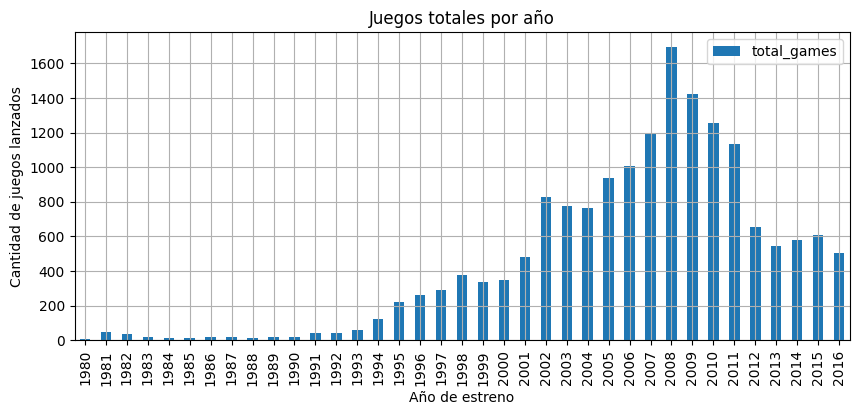

In [ ]:
df_por_periodo=df.groupby('year_of_release')['name'].count().reset_index()
df_por_periodo.rename(columns={'name':'total_games'}, inplace=True )

df_por_periodo.plot(x='year_of_release', y='total_games', figsize=[10,4], title='Juegos totales por año', xlabel='Año de estreno',ylabel='Cantidad de juegos lanzados', grid=True, kind='bar')
plt.show()



Como se puede observar, tanto en la gráfica como en la tabla, la cantidad de videojuegos lanzados al mercado fue aumentando claramente a partir de 1990, teniendo su máximo en el 2008. A partir de ese año, esta cifra ha comenzado a disminuir, llegando en 2016 a una cantidad muy parecida a la que se muestra en el año 2001. Esto no es necesariamente algo negativo, ya que podría deberse a que los creadores de videojuegos están priorizando la calidad sobre la cantidad. También es posible que los consumidores tengan algunos títulos favoritos a los cuales los desarrolladores están prestando más atención.

Es importante mencionar que en este primer análisis no se consideran los hábitos de consumo, sino solamente la cantidad de juegos lanzados anualmente, lo que no quiere decir necesariamente que los consumidores estén comprando menos.

In [ ]:
print(df.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')


In [ ]:
df_por_plataforma= df.groupby('platform')['total_sales'].sum().reset_index()
df_por_plataforma= df_por_plataforma.sort_values(by='total_sales', ascending=False)
print(df_por_plataforma.head(10))

   platform  total_sales
16      PS2      1062.33
28     X360       885.66
26      Wii       828.44
17      PS3       803.97
4        DS       746.86
15       PS       689.95
6       GBA       310.12
18      PS4       265.79
19      PSP       252.63
29       XB       249.02


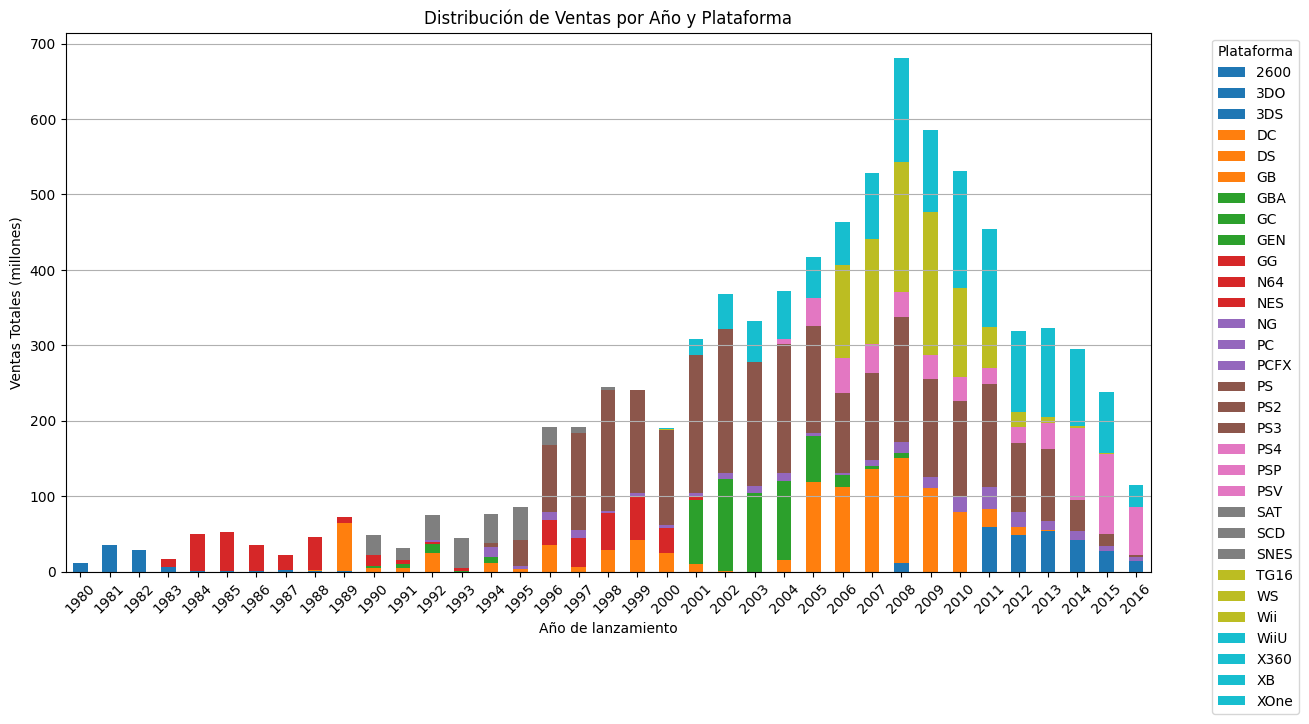

In [ ]:
df_ventas_anuales=df.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

df_pivot = df_ventas_anuales.pivot(index='year_of_release', columns='platform', values='total_sales')

df_pivot.plot(kind='bar', stacked=True, figsize=(14,7), colormap='tab10')

plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas Totales (millones)')
plt.title('Distribución de Ventas por Año y Plataforma')
plt.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()



In [ ]:
df_ventas = df_ventas_anuales[df_ventas_anuales['total_sales'] > 0]
ultimos_ventas = df_ventas[df_ventas['year_of_release'] == df_ventas['year_of_release'].max()]
plataformas_sin_ventas = df_ventas[~df_ventas['platform'].isin(ultimos_ventas['platform'])]
plataformas_sin_ventas = plataformas_sin_ventas.drop_duplicates(subset='platform')
print(plataformas_sin_ventas[['platform']])

    platform
0       2600
4        NES
8         DS
16        GB
23       GEN
25      SNES
32        GG
38        NG
39       SCD
41       3DO
47        PS
48       SAT
58      TG16
60       N64
63      PCFX
73        DC
87        WS
90       GBA
94       PS2
96        XB
100       GC
126      PSP


In [ ]:
primer_ultimo_anio = df_ventas_anuales[df_ventas_anuales['total_sales'] > 0] \
    .groupby('platform').agg(
        primer_anio=('year_of_release', 'min'),
        ultimo_anio=('year_of_release', 'max')
    ).reset_index()

primer_ultimo_anio['ciclo_vida'] = primer_ultimo_anio['ultimo_anio'] - primer_ultimo_anio['primer_anio']
primer_ultimo_anio=primer_ultimo_anio.sort_values(by='primer_anio', ascending=True)


print(primer_ultimo_anio[['platform', 'primer_anio', 'ultimo_anio', 'ciclo_vida']])


   platform  primer_anio  ultimo_anio  ciclo_vida
0      2600         1980         2008          28
11      NES         1983         1994          11
13       PC         1985         2016          31
4        DS         1985         2013          28
5        GB         1988         2008          20
8       GEN         1990         1994           4
23     SNES         1990         1999           9
9        GG         1992         1992           0
22      SCD         1993         1994           1
12       NG         1993         1996           3
1       3DO         1994         1995           1
15       PS         1994         2008          14
21      SAT         1994         1999           5
24     TG16         1995         1995           0
10      N64         1996         2008          12
14     PCFX         1996         1996           0
3        DC         1998         2008          10
25       WS         1999         2001           2
6       GBA         2000         2008           8


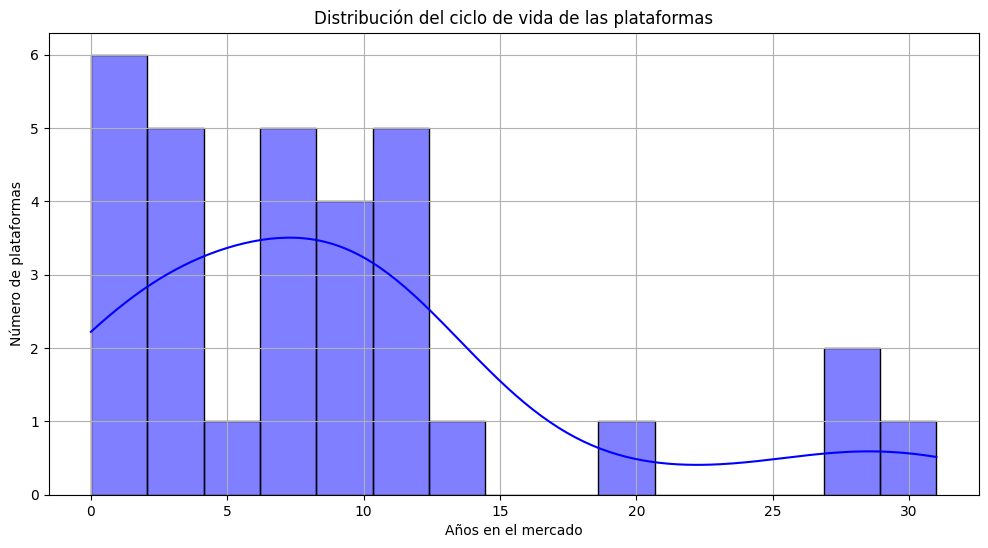

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(primer_ultimo_anio['ciclo_vida'], bins=15, kde=True, color='blue')

plt.title('Distribución del ciclo de vida de las plataformas')
plt.xlabel('Años en el mercado')
plt.ylabel('Número de plataformas')
plt.grid(True)

plt.show()

Al agrupar las ventas totales que han tenido las plataformas en estos años, nos damos cuenta de que las cinco más populares son:

*   PS2
*   X360
*   Wii
*   PS3
*   DS

Por otra parte, al graficar las ventas totales anuales, podemos apreciar que la gráfica es muy parecida a la que mostraba los lanzamientos anuales. Esto quiere decir que, de igual manera, se puede observar que el comportamiento de compra de los consumidores aumentó cada año, alcanzando su máximo en el año 2008, a partir del cual ha ido disminuyendo, llegando a niveles no vistos desde 1996.

Sobre el ciclo de vida de las plataformas, podemos darnos cuenta de que la mayoría de ellas, especialmente las más nuevas, tienen un ciclo de vida limitado. Como podemos apreciar en la tabla, las plataformas que surgieron en los primeros cinco años de los que tenemos registro duraron más de diez años. Por otro lado, en la gráfica que se muestra arriba, se puede observar que hay, en general, muy pocas plataformas que se sigan comprando después de los quince años.

Para continuar con el análisis, tomaremos la información a partir del año 2000, ya que fue desde ese año que hubo más lanzamientos de juegos y, de igual forma, fue cuando las plataformas tuvieron más ventas. La información de los años anteriores se seguirá utilizando para ciertos cálculos.

In [ ]:
df_ventas_anuales_actual = df_ventas_anuales[df_ventas_anuales['year_of_release'] >= 2000]
df_ventas_anuales_filtrado = df_ventas_anuales_actual.groupby('platform')['total_sales'].sum().reset_index()
df_ventas_anuales_filtrado=df_ventas_anuales_filtrado.sort_values(by='total_sales',ascending=False)
print(df_ventas_anuales_filtrado.head(15))

   platform  total_sales
10      PS2      1062.33
18     X360       885.66
16      Wii       828.44
11      PS3       803.97
3        DS       746.84
5       GBA       310.12
12      PS4       265.79
13      PSP       252.63
19       XB       249.02
1       3DS       245.64
6        GC       193.75
8        PC       188.61
20     XOne       145.05
9        PS       135.81
17     WiiU        76.24


En esta tabla podemos apreciar las 15 plataformas que historicamente (con los datos proporcionados) tienen mayores ventas a partir del 2000.

In [ ]:
df_ventas_anuales_filtrado_primer_ultimo_anio = pd.merge(df_ventas_anuales_filtrado, primer_ultimo_anio[['primer_anio', 'ultimo_anio','platform']], how='inner', on='platform')
df_ventas_anuales_filtrado_primer_ultimo_anio = df_ventas_anuales_filtrado_primer_ultimo_anio.sort_values(by='ultimo_anio')
print(df_ventas_anuales_filtrado_primer_ultimo_anio.head(15))


   platform  total_sales  primer_anio  ultimo_anio
20       WS         0.96         1999         2001
5       GBA       310.12         2000         2008
10       GC       193.75         2001         2008
13       PS       135.81         1994         2008
17       GB        28.31         1988         2008
18     2600        10.43         1980         2008
16      N64        36.86         1996         2008
8        XB       249.02         2000         2008
19       DC         7.28         1998         2008
0       PS2      1062.33         2000         2011
4        DS       746.84         1985         2013
7       PSP       252.63         2004         2015
6       PS4       265.79         2013         2016
1      X360       885.66         2005         2016
2       Wii       828.44         2006         2016


En esta tabla, muestra las mismas plataformas que vimos previamente que tenían más ventas a partir del año 2000, pero se incluyó el último año en el que se lanzó un juego para estas plataformas.

Como se puede apreciar, las siguientes plataformas son las que siguen sacando juegos y que tienen ventas altas:

* PS4
* 3DS
* PC

Estas plataformas son rentables pues al seguir lanzando nuevos juegos siguen teniendo presencia en el mercado, algo importante que podríamos rescatar, es que la plataforma con más ventas historicas es el PS2 lo cual nos habla de la popularidad que el Play Station tiene con los consumidores por lo que es bueno que dentro de nuestra lista de plataformas rentables esté el Play Station 4 que es el más reciente.



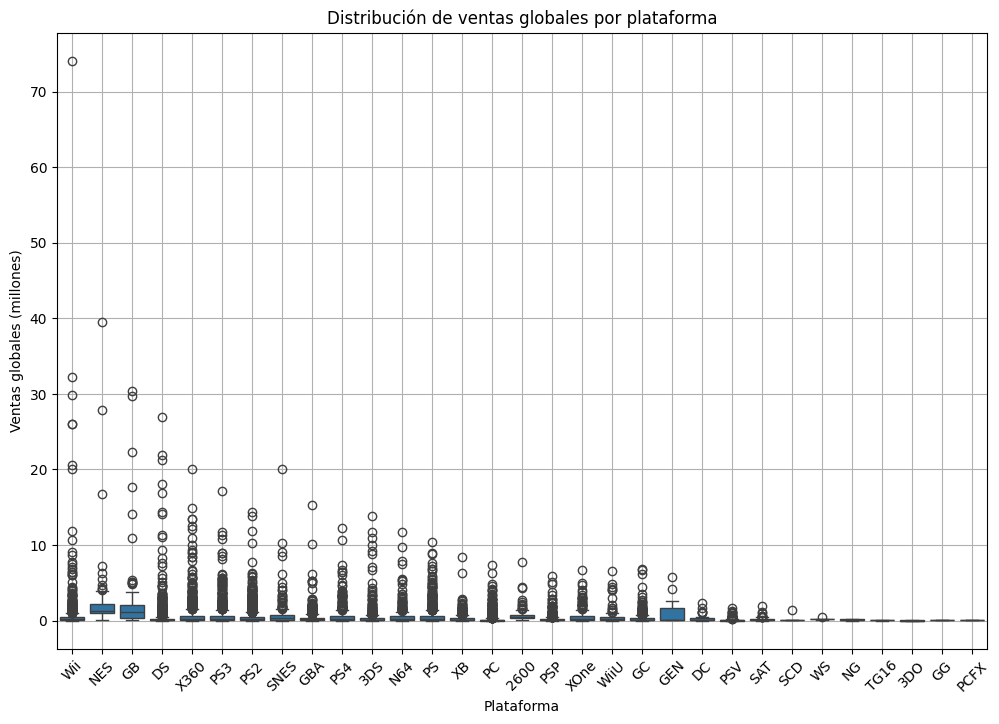

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='platform', y='total_sales', data=df)


plt.title('Distribución de ventas globales por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales (millones)')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

Con esta gráfica podemos apreciar que plataformas como Wii, NES, DS tienen distribuciones amplias, lo cual no indica que han tenido juegos con ventas altas. Cabe mencionar que las tres son consolas producidas por Nintendo lo cual nos indica que deberíamos considerar invertir en la consola más nueva de esta plataforma. Tambien hay varios puntos fuera de los limites de las cajas que indica que hay juegos que tienen excepcionalmente altas en varias plataformas.

                  mean  median      sum
genre                                  
Action        0.462918    0.17  1559.57
Sports        0.509693    0.20  1196.76
Shooter       0.716810    0.21   948.34
Role-Playing  0.584065    0.17   874.93
Platform      0.874640    0.25   776.68
Misc          0.416069    0.14   728.12
Racing        0.522474    0.17   652.57
Fighting      0.484299    0.19   411.17
Simulation    0.411501    0.14   359.24
Puzzle        0.396879    0.10   230.19
Adventure     0.169685    0.05   221.10
Strategy      0.239209    0.09   163.38


/tmp/ipython-input-21-3408921266.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_sales.index, y=genre_sales.values, palette='viridis')


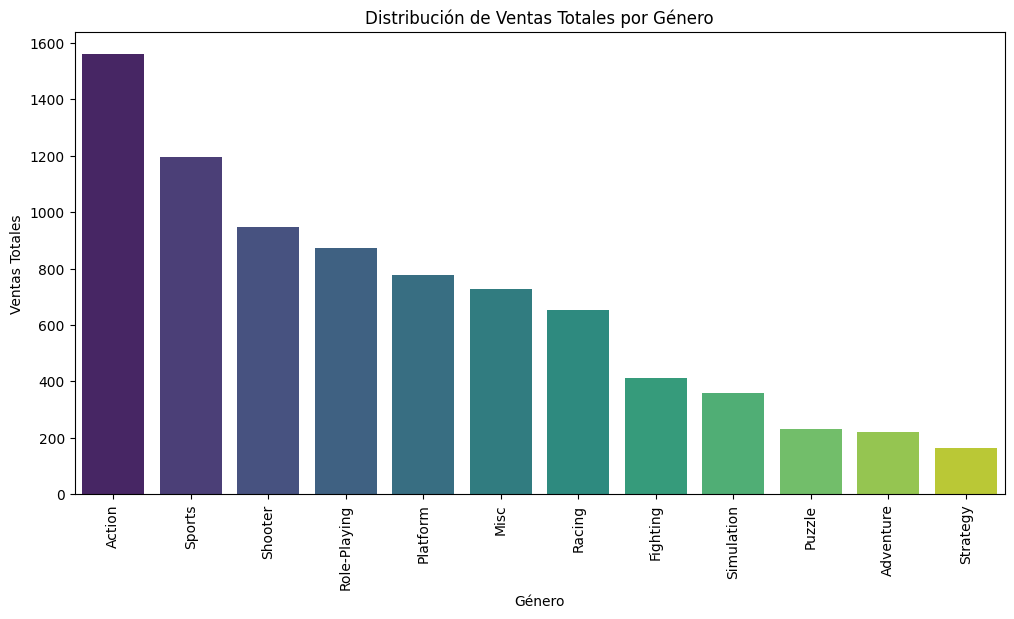

In [ ]:
genre_sales = df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
genre_sales_stats = df.groupby('genre')['total_sales'].agg(['mean', 'median', 'sum']).sort_values(by='sum', ascending=False)
print(genre_sales_stats)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sales.index, y=genre_sales.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribución de Ventas Totales por Género')
plt.xlabel('Género')
plt.ylabel('Ventas Totales')
plt.show()



Ahora que tenemos la información sobre las consolas en las que podemos invertir, también es importante ver cuales son los géneros que mayor alcance tienen para poder tomar decisiones informadas al decidir que tipos de juegos son los que tienen mayores ventas, como podemos ver en la gráfica los juegos de acción son los favoritos de los consumidores, seguidos de los de deportes, por el contrario, los juegos que tienen menores ventas son los de puzzles, aventura y estrategia, esto es importante tener en cuenta para poder decidir cuales juegos incluir en la tienda que nos generes las mayores ventas posibles.

## 4.- PERFIL DE USUARIO POR REGIÓN

In [ ]:
df_ventas_por_plataforma = df.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum().reset_index()


In [ ]:
ventas_na=df_ventas_por_plataforma[['platform','na_sales']]
ventas_na=ventas_na.sort_values(by='na_sales',ascending=False)

print(ventas_na.head(5))

   platform  na_sales
28     X360    602.47
16      PS2    583.84
26      Wii    496.90
17      PS3    393.49
4        DS    382.40


In [ ]:
ventas_eu=df_ventas_por_plataforma[['platform','eu_sales']]
ventas_eu=ventas_eu.sort_values(by='eu_sales',ascending=False)

print(ventas_eu.head(5))

   platform  eu_sales
16      PS2    339.29
17      PS3    330.29
28     X360    270.76
26      Wii    262.21
15       PS    213.61


In [ ]:
ventas_jp=df_ventas_por_plataforma[['platform','jp_sales']]
ventas_jp=ventas_jp.sort_values(by='jp_sales',ascending=False)

print(ventas_jp.head(5))

   platform  jp_sales
4        DS    175.57
15       PS    139.82
16      PS2    139.20
23     SNES    116.55
2       3DS    100.67


In [ ]:
ventas_por_region=df_ventas_por_plataforma[['na_sales','eu_sales','jp_sales']].sum()
print(ventas_por_region)

na_sales    4400.57
eu_sales    2424.14
jp_sales    1297.34
dtype: float64


Con la información recabada sobre, las ventas por región, podemos apreciar que la región con más ventas es norteamerica, seguida de Europa y por ultimo Japón. Es importante mencionar también que las plataformas con más ventas en cada región varían principalmente en Japón, aunque la plataforma que se repite en las tres regiones es el PlayStation2.

También es interesante ver que dentro de las plataformas más populares en cada región, no se encuentra PC, aunque previamente vimos que sí era una plataforma con ventas altas y que seguía sacando juegos, esto puede ser ya que los juegos para computadoras se han usado desde hace mucho tiempo y constantemente ya que no es una plataforma que se esté actualizando constantemente, así que también es una buena opción de inversión ya que sigue presente.

In [ ]:
ventas_por_genero=df.groupby('genre')[['na_sales','eu_sales','jp_sales']].sum().reset_index()

In [ ]:
genero_na=ventas_por_genero[['genre','na_sales']]
genero_na=genero_na.sort_values(by='na_sales',ascending=False)
print(genero_na.head(5))

       genre  na_sales
0     Action    879.01
10    Sports    684.43
8    Shooter    592.24
4   Platform    445.50
3       Misc    407.27


In [ ]:
genero_eu=ventas_por_genero[['genre','eu_sales']]
genero_eu=genero_eu.sort_values(by='eu_sales',ascending=False)
print(genero_eu.head(5))

      genre  eu_sales
0    Action    519.13
10   Sports    376.79
8   Shooter    317.34
6    Racing    236.51
3      Misc    212.74


In [ ]:
genero_jp=ventas_por_genero[['genre','jp_sales']]
genero_jp=genero_jp.sort_values(by='jp_sales',ascending=False)
print(genero_jp.head(5))

           genre  jp_sales
7   Role-Playing    355.41
0         Action    161.43
10        Sports    135.54
4       Platform    130.83
3           Misc    108.11


De igual manera, guiandonos por el género, la región que tiene resultados diferentes a los esperados es Japón ya que tanto, Norte America como Europa, muestran los siguientes generos más populares:

* Action
* Sports
* Shooter

Esto coincide con la gráfica que realizamos previamente, mientras que Japón también tiene los primeros dos generos en su top cinco pero su genero favorito es Role-Playing

In [ ]:
rating_ventas=df.groupby('rating')[['na_sales','eu_sales','jp_sales']].sum().reset_index()
print(rating_ventas)

    rating  na_sales  eu_sales  jp_sales
0       AO      1.26      0.61      0.00
1        E   1292.99    710.25    198.11
2     E10+    353.32    188.52     40.20
3       EC      1.53      0.11      0.00
4      K-A      2.56      0.27      1.46
5        M    748.48    483.97     64.24
6       RP      0.00      0.08      0.00
7        T    759.75    427.03    151.40
8  Unknown   1240.68    613.30    841.93


In [ ]:
rating_na=rating_ventas[['rating','na_sales']]
rating_na=rating_na.sort_values(by='na_sales',ascending=False)
print(rating_na)

    rating  na_sales
1        E   1292.99
8  Unknown   1240.68
7        T    759.75
5        M    748.48
2     E10+    353.32
4      K-A      2.56
3       EC      1.53
0       AO      1.26
6       RP      0.00


In [ ]:
rating_eu=rating_ventas[['rating','eu_sales']]
rating_eu=rating_eu.sort_values(by='eu_sales',ascending=False)
print(rating_eu)

    rating  eu_sales
1        E    710.25
8  Unknown    613.30
5        M    483.97
7        T    427.03
2     E10+    188.52
0       AO      0.61
4      K-A      0.27
3       EC      0.11
6       RP      0.08


In [ ]:
rating_jp=rating_ventas[['rating','jp_sales']]
rating_jp=rating_jp.sort_values(by='jp_sales',ascending=False)
print(rating_eu)

    rating  eu_sales
1        E    710.25
8  Unknown    613.30
5        M    483.97
7        T    427.03
2     E10+    188.52
0       AO      0.61
4      K-A      0.27
3       EC      0.11
6       RP      0.08


Sobre los ratings, podemos observar que en las tres ubicaciones si quitamos 'Unknown' las que más ventas tienen son:

* E (Everyone): para todos
* M (Mature): mayores de 17
* T (Teen): mayores de 13 años

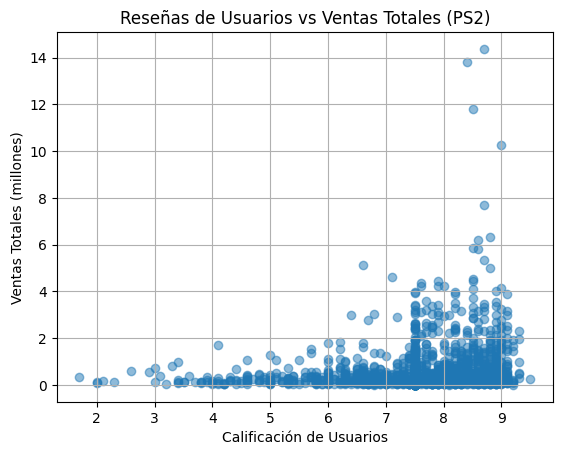

In [ ]:
df_ps2 = df[df['platform'] == 'PS2']


plt.scatter(df_ps2['user_score'], df_ps2['total_sales'], alpha=0.5)
plt.title('Reseñas de Usuarios vs Ventas Totales (PS2)')
plt.xlabel('Calificación de Usuarios')
plt.ylabel('Ventas Totales (millones)')
plt.grid(True)
plt.show()


In [ ]:
df_ps2 = df[df['platform'] == 'PS2']

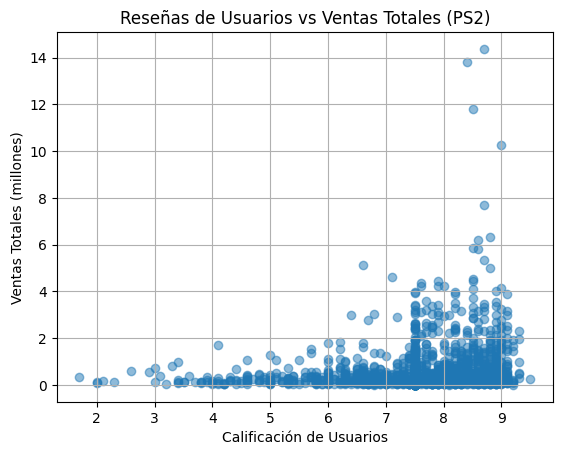

In [ ]:
plt.scatter(df_ps2['user_score'], df_ps2['total_sales'], alpha=0.5)
plt.title('Reseñas de Usuarios vs Ventas Totales (PS2)')
plt.xlabel('Calificación de Usuarios')
plt.ylabel('Ventas Totales (millones)')
plt.grid(True)
plt.show()


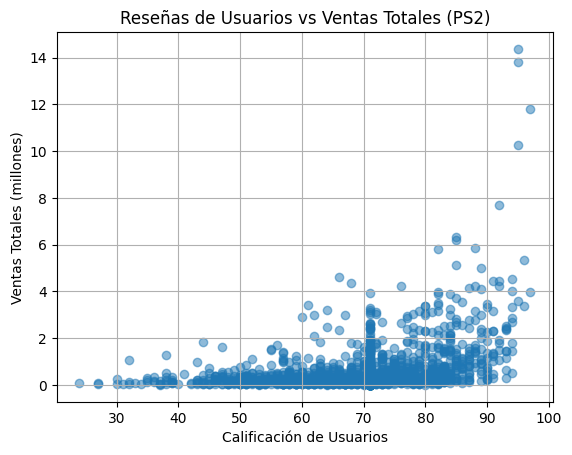

In [ ]:
plt.scatter(df_ps2['critic_score'], df_ps2['total_sales'], alpha=0.5)
plt.title('Reseñas de Usuarios vs Ventas Totales (PS2)')
plt.xlabel('Calificación de Usuarios')
plt.ylabel('Ventas Totales (millones)')
plt.grid(True)
plt.show()

In [ ]:
correlacion_usuario = df_ps2['user_score'].corr(df_ps2['total_sales'])

correlacion_profesional = df_ps2['critic_score'].corr(df_ps2['total_sales'])

print(f'Correlación entre Reseñas de Usuarios y Ventas Totales (PS4): {correlacion_usuario:.2f}')
print(f'Correlación entre Reseñas de Profesionales y Ventas Totales (PS4): {correlacion_profesional:.2f}')

Correlación entre Reseñas de Usuarios y Ventas Totales (PS4): 0.19
Correlación entre Reseñas de Profesionales y Ventas Totales (PS4): 0.35


Como podemos ver, la correlación que se muestran las ventas totales con las reseñas que hacen los ususarios es de 0.19 lo que es un porcentaje bajo, mientras que la correlación de las reseñas profesionales y las ventas es de 0.35 lo cual es moderado.

## 5.- HIPÓTESIS


Se desarrollaron dos hipotesis:

* Hipótesis nula: Las calificaciones promedio de usuarios para Xbox One y PC son iguales.

* Hipótesis alternativa: Las calificaciones promedio de usuarios para Xbox One y PC son diferentes.



* Hipóteis nula: Las calificaciones promedio de usuarios para Xbox One y PC son iguales.

* Hipótesis alternativa: Las calificaciones promedio de los usuarios para Xbox One y PC son diferentes.

In [ ]:
xbox_scores = df[df['platform'] == 'XOne']['user_score'].dropna()
pc_scores = df[df['platform'] == 'PC']['user_score'].dropna()

print("Prueba de normalidad:")
print("Xbox One:", shapiro(xbox_scores))
print("PC:", shapiro(pc_scores))

Prueba de normalidad:
Xbox One: ShapiroResult(statistic=np.float64(0.8857789646266447), pvalue=np.float64(1.0873619372280523e-12))
PC: ShapiroResult(statistic=np.float64(0.8708337952333345), pvalue=np.float64(1.3025518173849157e-27))


In [ ]:
accion_scores = df[df['genre'] == 'Action']['user_score'].dropna()
deportes_scores = df[df['genre'] == 'Sports']['user_score'].dropna()

print("\nPrueba de homogeneidad de varianza:")
print("Xbox One vs PC:", levene(xbox_scores, pc_scores))
print("Acción vs Deportes:", levene(accion_scores, deportes_scores))


Prueba de homogeneidad de varianza:
Xbox One vs PC: LeveneResult(statistic=np.float64(7.777487276480662e-05), pvalue=np.float64(0.9929649852182456))
Acción vs Deportes: LeveneResult(statistic=np.float64(0.16699629968166063), pvalue=np.float64(0.6828105166182066))


Para aceptar o rechazar la hipotesis nula, primero se realizaron una prueba de normalidad y otra de homogeneidad de varianza para elegir cual era el metodo correcto para comprobar la hipotesis, los resultados que se obtuvieron fueron los siguientes:

* Los p-values tanto de las plataformas, como de los generos son muy bajos (p<0.05) esto quiere decir que los datos no tienen una distribución normal.

* Los p-values de la prueba de homogeneidad si son mayores que 0.05 por lo que podemos deicr que no hay evidencia para rechazar la homogeneidad de las varianzas. Teniendo en cuenta que ambos criterios deberían cumplirse, no podemos utilizar la prueva T de Student, por lo que se eligió la prueba Mann-Whiteny

In [ ]:
u_stat_xbox_pc, p_val_xbox_pc = mannwhitneyu(xbox_scores, pc_scores, alternative='two-sided')
print("\nPrueba de Mann-Whitney para Xbox One vs PC:")
print(f"Estadístico U: {u_stat_xbox_pc}, p-valor: {p_val_xbox_pc}")



Prueba de Mann-Whitney para Xbox One vs PC:
Estadístico U: 91883.0, p-valor: 7.3058291469478064e-09


In [ ]:
u_stat_accion_deportes, p_val_accion_deportes = mannwhitneyu(accion_scores, deportes_scores, alternative='two-sided')
print("\nPrueba de Mann-Whitney para Acción vs Deportes:")
print(f"Estadístico U: {u_stat_accion_deportes}, p-valor: {p_val_accion_deportes}")




Prueba de Mann-Whitney para Acción vs Deportes:
Estadístico U: 3899946.0, p-valor: 0.33476254843219955


Después de realizar la priueba para comprobar ambas hipotesis podemos decir que:

* Rechazamos la primera hipotesis nula por lo que las calificaciones promedio para Xbox One y P son diferentes.
* No podemos rechazar la segunda hipótesis nula, así que podemos decir que las calificaciones promedio para Acción y Deportes son iguales.

## 6.- CONCLUSIÓN

Se realizó una limpieza y estandarización exhaustiva del DataFrame, resolviendo problemas en los tipos de datos y valores ausentes. La columna 'year_of_release' se convirtió a entero, y los valores "tbd" en 'user_score' fueron reemplazados por NaN. Se completaron los valores faltantes usando la moda, la mediana o una etiqueta genérica como "unknown", dependiendo de la columna. Esto asegura una mayor precisión en el análisis posterior.

Con base en el análisis, encontramos un aumento en los lanzamientos y ventas de videojuegos hasta 2008, seguido de una disminución progresiva. Esto podría deberse a una mayor priorización de la calidad sobre la cantidad o a la atención en títulos y plataformas populares. Las plataformas con mayores ventas históricas son PS2, X360, Wii, PS3 y DS, mientras que las plataformas más activas y rentables actualmente son PS4, 3DS y PC.

Sobre el ciclo de vida de las plataformas, las más antiguas tienden a tener ciclos de vida más largos, mientras que las más recientes son reemplazadas rápidamente por nuevas versiones. PlayStation sigue siendo una marca relevante, reflejado en las ventas del PS2 y el éxito continuo del PS4. Nintendo también destaca con plataformas como Wii, NES y DS.

Es importante mencionr que los géneros de mayor éxito son Acción, Deportes y Shooter, mientras que Puzzle, Aventura y Estrategia tienen menores ventas. Este dato es crucial para decisiones estratégicas en inversión y desarrollo de nuevos títulos.

También analizamos el comportamiento de la ventas por región, lo que nos mostró que norteamérica lidera en ventas, seguida de Europa y Japón. El PlayStation 2 es la única consola presente en las tres regiones. Japón muestra diferencias en preferencias de género, destacando Role-Playing sobre los géneros populares en Norteamérica y Europa. Aunque el PC tiene altas ventas globales, no es la plataforma más popular en ninguna región específica, lo que sugiere un comportamiento de consumo diferente.

Los juegos con calificaciones "E" (Everyone), "M" (Mature) y "T" (Teen) son los que generan más ventas, indicando una amplia audiencia y una buena aceptación de contenido tanto familiar como más adulto.

Por ultimo planteamos algunas hipótesis que nos dieron los siguientes resultados:

* Se rechazó la hipótesis nula sobre las calificaciones promedio de Xbox One y PC, indicando diferencias significativas en las valoraciones de los usuarios entre ambas plataformas.
* No se pudo rechazar la hipótesis nula para los géneros de Acción y Deportes, lo que sugiere que sus calificaciones promedio son estadísticamente iguales.

En resumen, el análisis revela que las tendencias del mercado han cambiado, pero ciertas plataformas y géneros siguen siendo fuertes. La información recopilada permitirá tomar decisiones estratégicas para enfocarse en plataformas y géneros rentables, ajustar la oferta por región y considerar los gustos de los consumidores para maximizar el éxito en el mercado.

In [ ]:
# Comprimir el proyecto: incluye notebook + carpeta data/
!zip -r proyecto.zip data *.ipynb

# Descargarlo a tu compu
from google.colab import files
files.download('proyecto.zip')


	zip warning: name not matched: *.ipynb
  adding: data/ (stored 0%)
  adding: data/games.csv (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>